Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [94]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import cv2
from glob import glob
from sklearn.metrics import accuracy_score, classification_report
from tensorflow import keras
keras = tf.keras
models = tf.keras.models
layers = tf.keras.layers
Sequential = tf.keras.models.Sequential
from keras.losses import CategoricalCrossentropy
from keras.layers.experimental import preprocessing
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [23]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2359 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [24]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [25]:
# Specify the target size
target_size = (180, 180)
# Specify the path to your image directory
image_dir = "/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

image_dir_test = "/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"

# # Create a new directory to save resized images
# output_dir = "/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Resized"
# os.makedirs(output_dir, exist_ok=True)

In [26]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2241
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [27]:
batch_size = 32
img_height = 180
img_width = 180

# Set the seed for reproducibility
seed = 123
tf.random.set_seed(seed)



Use 80% of the images for training, and 20% for validation.

In [84]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2241 files belonging to 9 classes.
Using 1793 files for training.


In [85]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2241 files belonging to 9 classes.
Using 448 files for validation.


In [86]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [87]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Found 2241 files belonging to 9 classes.


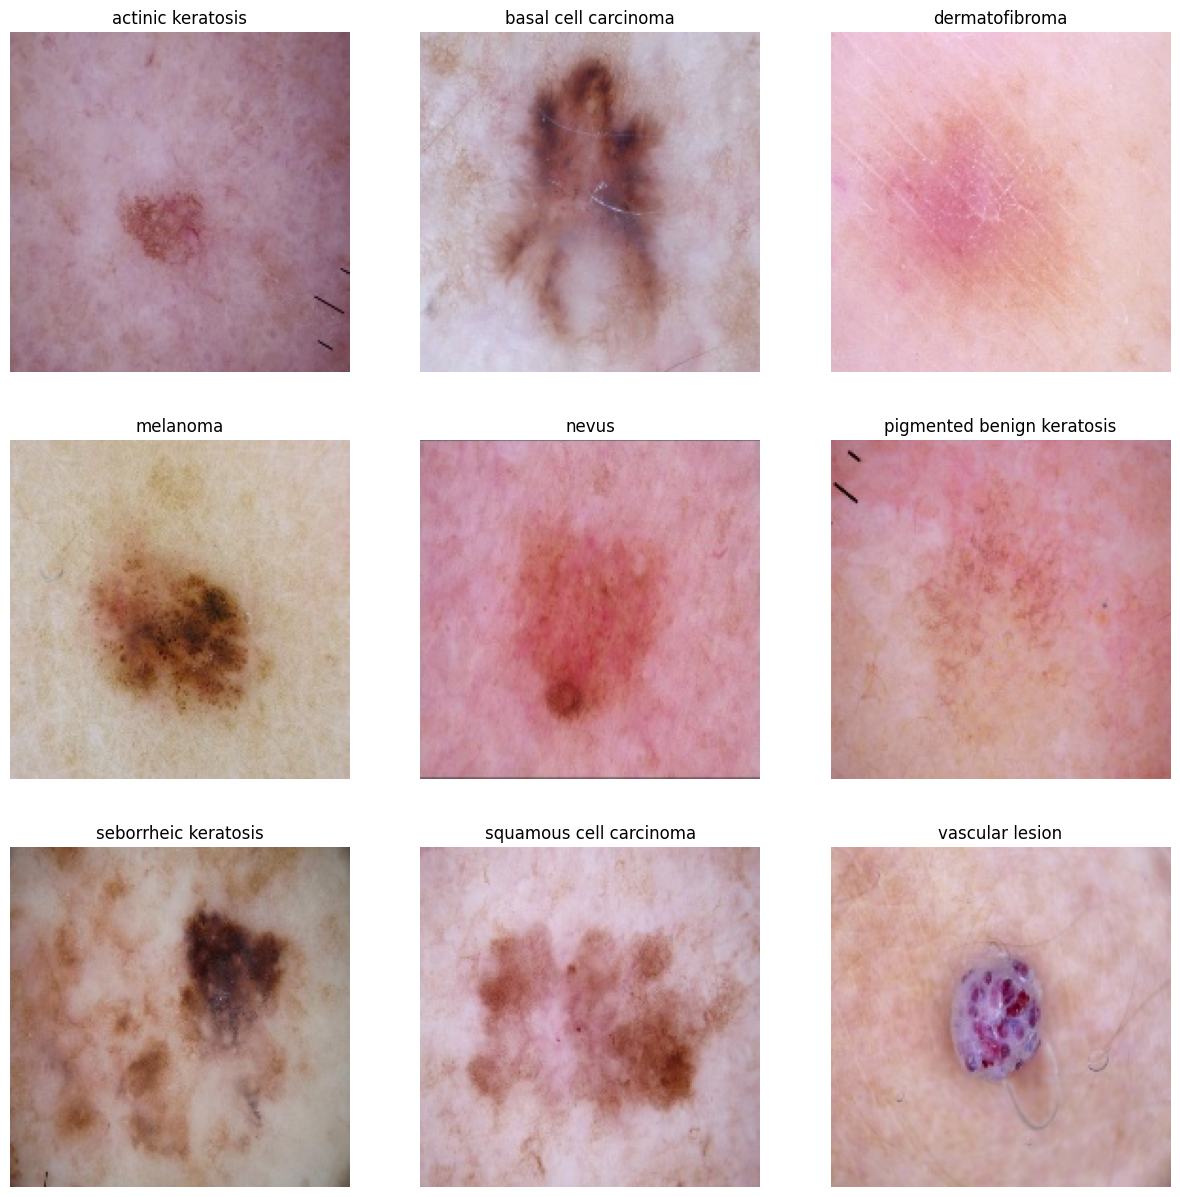

In [32]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
#Visualize one instance of all the class present in the dataset.

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180,180),
    label_mode='categorical',seed=123
    )

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Visualize distribution of classes in the training dataset.

In [34]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,vascular lesion,139
2,squamous cell carcinoma,181
3,nevus,357
4,basal cell carcinoma,378
5,dermatofibroma,95
6,pigmented benign keratosis,462
7,seborrheic keratosis,77
8,melanoma,438


<Axes: xlabel='No. of Image', ylabel='Class'>

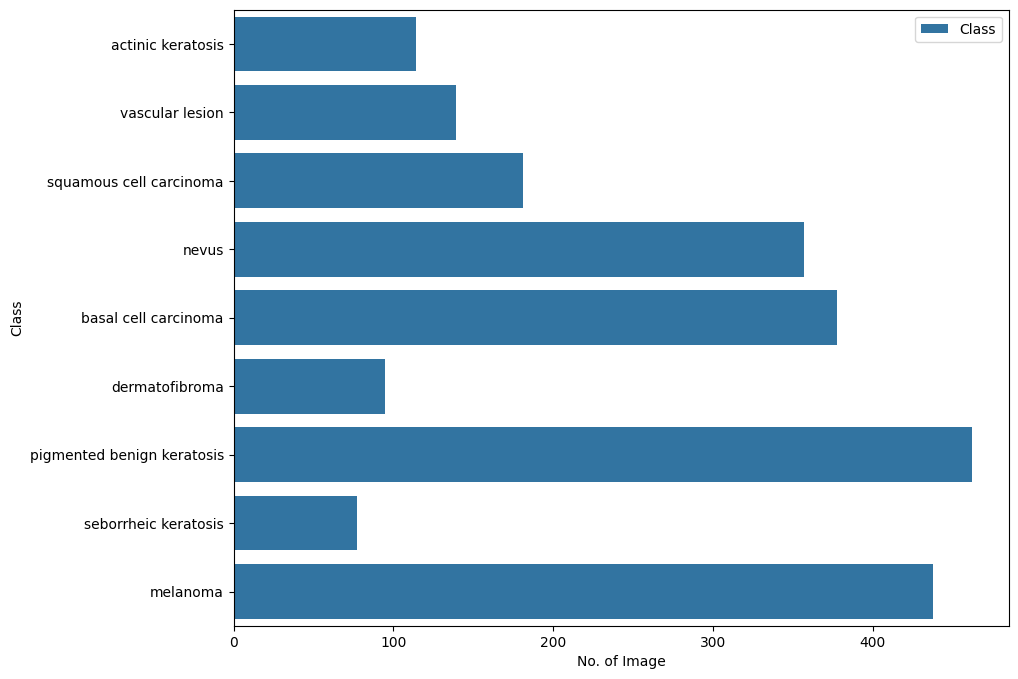

In [35]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df, label="Class")

We can observe that there is class imbalance here

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [36]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [193]:
### Your code goes here
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(preprocessing_layers)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Activation(activ))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Activation(activ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation(activ))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(Activation(activ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), Activation('softmax')))

## Number of classes is 9
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_20 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_77 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 activation_100 (Activation  (None, 178, 178, 32)      0         
 )                                                               
                                                                 
 batch_normalization_72 (Ba  (None, 178, 178, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_78 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 activation_101 (Activation  (None, 176, 176, 32)    

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [194]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'sgd'

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )



In [195]:
# View the summary of all layers
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_20 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_77 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 activation_100 (Activation  (None, 178, 178, 32)      0         
 )                                                               
                                                                 
 batch_normalization_72 (Ba  (None, 178, 178, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_78 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 activation_101 (Activation  (None, 176, 176, 32)    

### Train the model

In [196]:
epochs = 30
batch_size = 32

history_first = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
57/57 [==============================] - 5s 53ms/step - loss: 7.1388 - accuracy: 0.2482 - val_loss: 6.7257 - val_accuracy: 0.1228
Epoch 2/30
57/57 [==============================] - 3s 48ms/step - loss: 1.7460 - accuracy: 0.4088 - val_loss: 6.6712 - val_accuracy: 0.0737
Epoch 3/30
57/57 [==============================] - 3s 51ms/step - loss: 1.6112 - accuracy: 0.4590 - val_loss: 7.2418 - val_accuracy: 0.1585
Epoch 4/30
57/57 [==============================] - 3s 50ms/step - loss: 1.4378 - accuracy: 0.5003 - val_loss: 7.9122 - val_accuracy: 0.1518
Epoch 5/30
57/57 [==============================] - 3s 50ms/step - loss: 1.3450 - accuracy: 0.5298 - val_loss: 5.5853 - val_accuracy: 0.1920
Epoch 6/30
57/57 [==============================] - 3s 50ms/step - loss: 1.2777 - accuracy: 0.5494 - val_loss: 5.1803 - val_accuracy: 0.2857
Epoch 7/30
57/57 [==============================] - 3s 50ms/step - loss: 1.2908 - accuracy: 0.5661 - val_loss: 3.7165 - val_accuracy: 0.2098
Epoch 8/30
57

### Visualizing training results

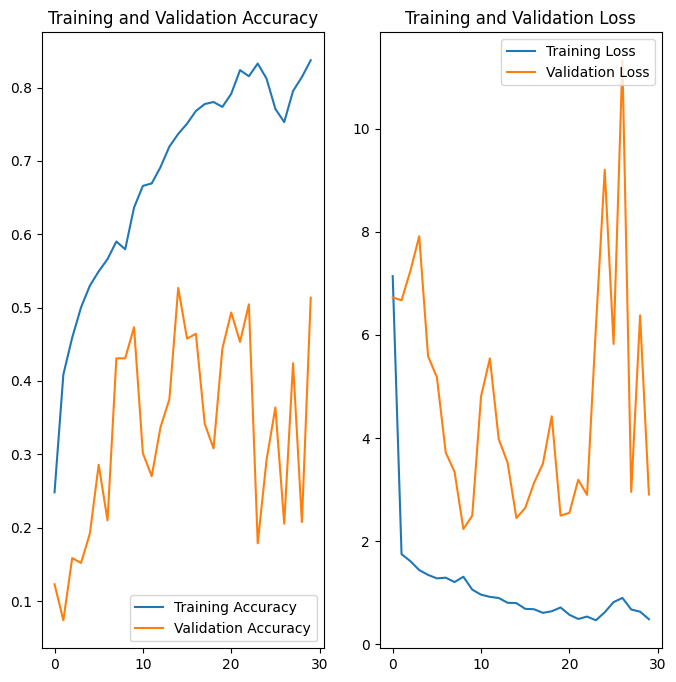

In [197]:
acc = history_first.history['accuracy']
val_acc = history_first.history['val_accuracy']

loss = history_first.history['loss']
val_loss = history_first.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model Overfit or Underfit?

In [198]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 1s 22ms/step - loss: 2.9045 - accuracy: 0.5134
Accuracy:  0.8510875701904297
Validation Accuracy:  0.5133928656578064
Loss:  0.46693387627601624
Validation Loss 2.9044597148895264


#### Clearly its overfitting on train data  and very low accuracy

### Using Augmentor for class imbalance

In [90]:
pip install Augmentor

In [91]:
path_to_training_dataset="/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=180x180 at 0x7F84C05E2320>: 100%|██████████| 500/500 [00:04<00:00, 111.72 Samples/s]


Initialised with 378 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7F85E0412D70>: 100%|██████████| 500/500 [00:03<00:00, 128.61 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7F84C05CBD60>: 100%|██████████| 500/500 [00:03<00:00, 133.09 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=180x180 at 0x7F86EC698C10>: 100%|██████████| 500/500 [00:03<00:00, 129.38 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7F84C05CCB20>: 100%|██████████| 500/500 [00:03<00:00, 131.66 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7F852D534250>: 100%|██████████| 500/500 [00:03<00:00, 132.63 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=180x180 at 0x7F852426C8E0>: 100%|██████████| 500/500 [00:03<00:00, 125.72 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7F8716DA63B0>: 100%|██████████| 500/500 [00:03<00:00, 132.25 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7F85244A31F0>: 100%|██████████| 500/500 [00:03<00:00, 134.64 Samples/s]


In [92]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [96]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:3]

['/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_9717ce46-348d-463b-a24e-5aa869d284d8.jpg',
 '/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_dd7a460a-1ebf-4f61-b916-e84e4b790bcc.jpg',
 '/content/gdrive/MyDrive/upgrad/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_c92d34ff-ef59-4c97-ae55-4f4f1eb8c386.jpg']

In [99]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:3]

['actinic keratosis', 'actinic keratosis', 'actinic keratosis']

In [100]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [101]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [102]:
new_df['Label'].value_counts()

actinic keratosis             500
vascular lesion               500
squamous cell carcinoma       500
nevus                         500
basal cell carcinoma          500
dermatofibroma                500
pigmented benign keratosis    500
seborrheic keratosis          500
melanoma                      500
Name: Label, dtype: int64

### Todo:
### Train the model on the data created using Augmentor


In [121]:
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6741 files belonging to 9 classes.
Using 5393 files for training.


### Create a validation dataset

In [122]:
val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6741 files belonging to 9 classes.
Using 1348 files for validation.


In [185]:
### Your code goes here
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model_aug = Sequential()
model_aug .add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model_aug .add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model_aug .add(Activation(activ))
model_aug .add(BatchNormalization())
model_aug .add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model_aug .add(Activation(activ))
model_aug .add(BatchNormalization())
model_aug .add(MaxPooling2D(pool_size=(2, 2)))
model_aug .add(Dropout(0.25))

model_aug .add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_aug .add(Activation(activ))
model_aug .add(BatchNormalization())
model_aug .add(Conv2D(64, kernel_size=(3, 3)))
model_aug .add(Activation(activ))
model_aug .add(BatchNormalization())
model_aug .add(MaxPooling2D(pool_size=(2, 2)))
model_aug .add(Dropout(0.25))

model_aug .add(Flatten())
model_aug .add(Dense(512, activation='relu'))
model_aug .add(Activation('relu'))
model_aug .add(Dropout(0.5))
model_aug .add(Dense(len(class_names), Activation('softmax')))

## Number of classes is 9
model_aug .summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_65 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 activation_82 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_60 (Ba  (None, 178, 178, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_66 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 activation_83 (Activation)  (None, 176, 176, 32)      0         
                                                     

### Compile your model (Choose optimizer and loss function appropriately)

In [202]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'sgd'

model_aug .compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )


### Training the model

In [203]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history_aug = model_aug .fit(
  train_ds_aug,
  batch_size= batch_size,
  validation_data= val_ds_aug,
  epochs= epochs
)

Epoch 1/30
169/169 [==============================] - 11s 55ms/step - loss: 3.6316 - accuracy: 0.3338 - val_loss: 9.8290 - val_accuracy: 0.1513
Epoch 2/30
169/169 [==============================] - 9s 53ms/step - loss: 1.4760 - accuracy: 0.4689 - val_loss: 3.8072 - val_accuracy: 0.3249
Epoch 3/30
169/169 [==============================] - 9s 53ms/step - loss: 1.2350 - accuracy: 0.5494 - val_loss: 1.5256 - val_accuracy: 0.5957
Epoch 4/30
169/169 [==============================] - 9s 53ms/step - loss: 1.0575 - accuracy: 0.6173 - val_loss: 1.5251 - val_accuracy: 0.5697
Epoch 5/30
169/169 [==============================] - 9s 53ms/step - loss: 0.8969 - accuracy: 0.6718 - val_loss: 1.8429 - val_accuracy: 0.5274
Epoch 6/30
169/169 [==============================] - 9s 53ms/step - loss: 0.7759 - accuracy: 0.7143 - val_loss: 1.6541 - val_accuracy: 0.5786
Epoch 7/30
169/169 [==============================] - 9s 53ms/step - loss: 0.6926 - accuracy: 0.7449 - val_loss: 0.9071 - val_accuracy: 0.730

### Visualizing the results

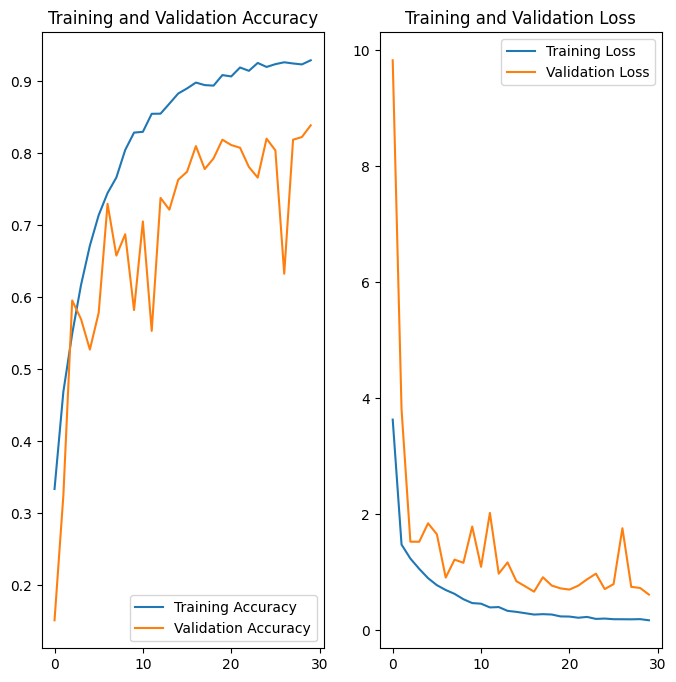

In [204]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Model Overfit or Underfit?**

In [208]:
loss, accuracy = model_aug.evaluate(train_ds_aug, verbose=1,)
loss_v, accuracy_v = model_aug.evaluate(val_ds_aug, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


43/43 [==============================] - 2s 37ms/step - loss: 0.6138 - accuracy: 0.8390
Accuracy:  0.9580938220024109
Validation Accuracy:  0.8390207886695862
Loss:  0.0886722281575203
Validation Loss 0.6137741208076477


#### Findings
> Overfitting is reduced after augmentation.
> Accuracy is also increased.